In [1]:
from Funciones_procesamiento import *

In [2]:
df=pd.read_csv('Wallapop_Modelo.csv')

In [3]:
df=marcas_lujo(df)

In [4]:
df=busca_averia(df)

In [5]:
df=busca_camper(df)

In [6]:
# train-test split
from sklearn.model_selection import train_test_split
X=df.drop(columns=['Modelo', 'Comentarios', 'Nombre usuario', 'Puntuacion',
                   'Nº Ventas','Ubicacion','latitud','longitud', 'Precio'])
y=np.log(df['Precio'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=6) #1 4  # random_state=42

xtrain_normal=X_train.copy()
xtest_normal=X_test.copy()

In [7]:
X_train, X_test = pre_model(X_train, X_test)

In [ ]:
# A continuación, se prueban diferentes modelos. Se han elegido los mejores hiperparámetros haciendo GridSearch y CrossValidation

[0]	validation_0-rmse:0.74869	validation_1-rmse:0.74883
[1]	validation_0-rmse:0.74347	validation_1-rmse:0.74360
[2]	validation_0-rmse:0.73839	validation_1-rmse:0.73851
[3]	validation_0-rmse:0.73411	validation_1-rmse:0.73421
[4]	validation_0-rmse:0.72827	validation_1-rmse:0.72832
[5]	validation_0-rmse:0.72250	validation_1-rmse:0.72249
[6]	validation_0-rmse:0.71683	validation_1-rmse:0.71678
[7]	validation_0-rmse:0.71120	validation_1-rmse:0.71109
[8]	validation_0-rmse:0.70562	validation_1-rmse:0.70547
[9]	validation_0-rmse:0.70013	validation_1-rmse:0.69993
[10]	validation_0-rmse:0.69469	validation_1-rmse:0.69445
[11]	validation_0-rmse:0.69007	validation_1-rmse:0.68982
[12]	validation_0-rmse:0.68472	validation_1-rmse:0.68444
[13]	validation_0-rmse:0.67943	validation_1-rmse:0.67910
[14]	validation_0-rmse:0.67419	validation_1-rmse:0.67382
[15]	validation_0-rmse:0.66902	validation_1-rmse:0.66862
[16]	validation_0-rmse:0.66393	validation_1-rmse:0.66349
[17]	validation_0-rmse:0.65888	validation

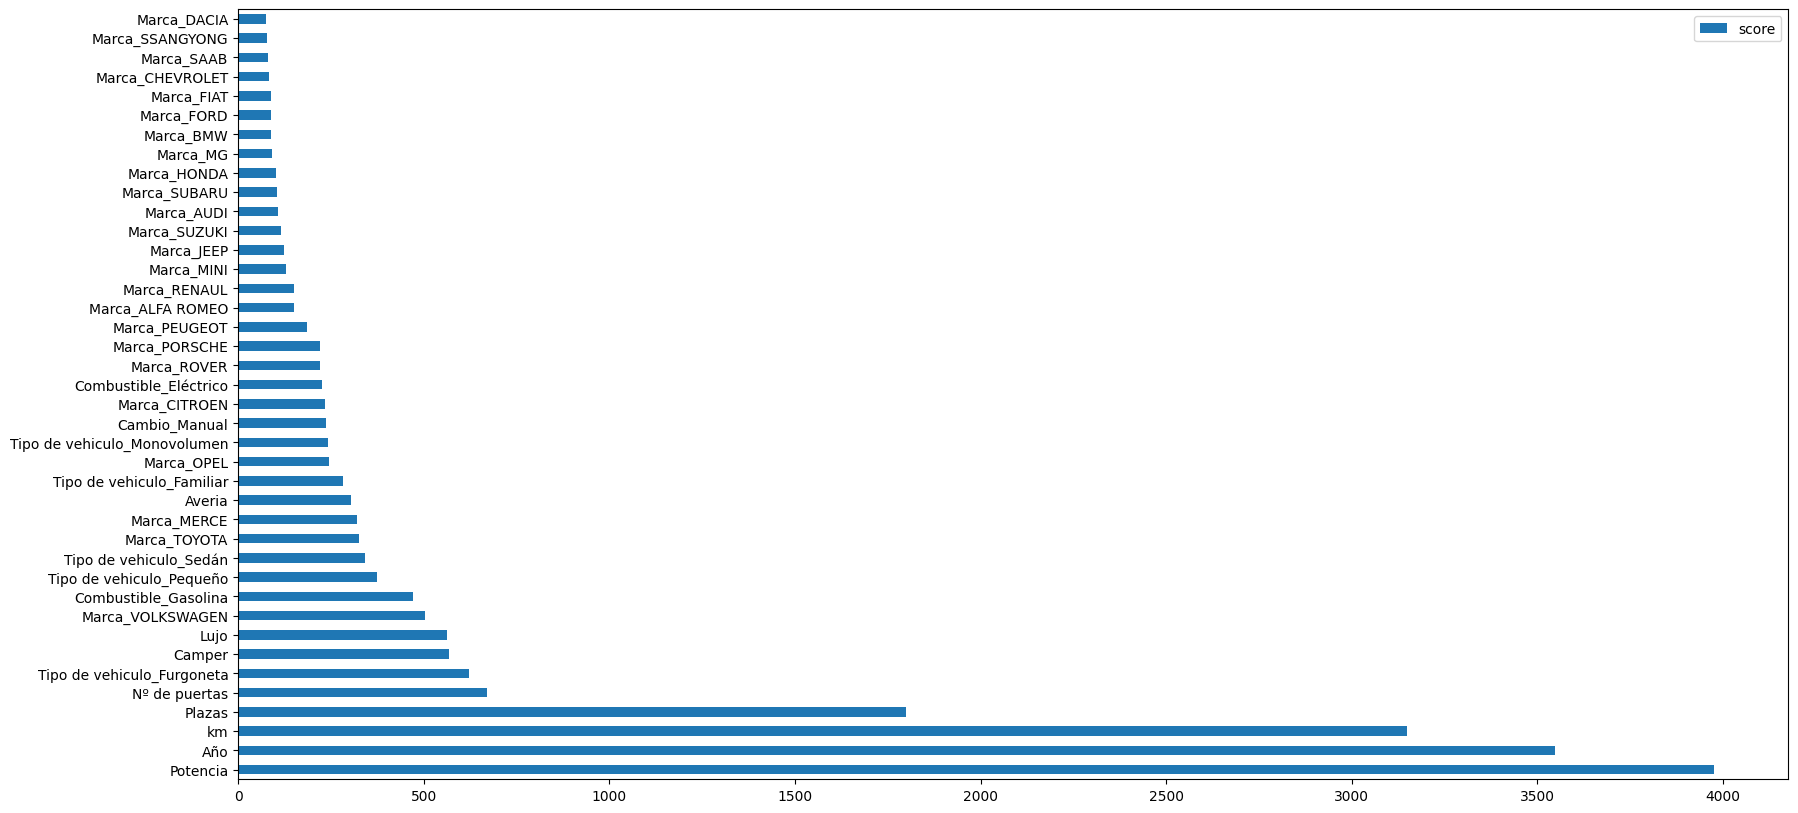

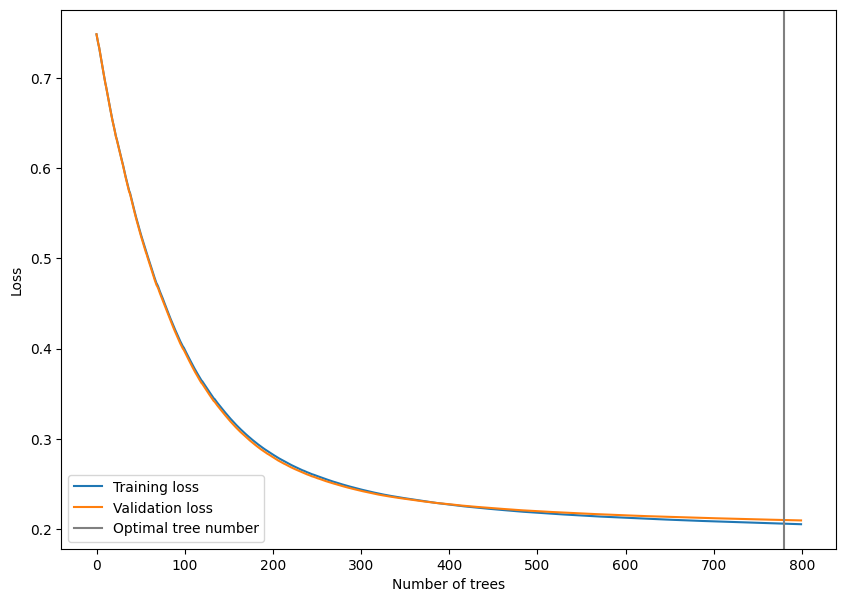

In [16]:
# XGBoost

xgbmodel = XGBRegressor()

model = xgb.XGBRegressor(n_estimators=800, max_depth=5, learning_rate=0.01,
                         reg_lambda= 0.1, min_child_weight=1, gamma=0.1,
                         subsample=0.8,colsample_bytree=0.8,
                        reg_alpha=0.1, early_stopping_rounds=10)
modelo=model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)])


results = model.evals_result()
total_trees=len(results["validation_0"]["rmse"]) #el numero total de arboles

yhat_train=model.predict(X_train)
yhat_test=model.predict(X_test)

print('R^2 score Train -->',r2_score(y_train,yhat_train))
print('R^2 score Test -->',r2_score(y_test, yhat_test))
print('RMSE Train -->',(mean_squared_error(np.exp(y_train),np.exp(yhat_train))**(1/2)))
print('RMSE TEST -->',(mean_squared_error(np.exp(y_test), np.exp(yhat_test))**(1/2)))

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(total_trees-20, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [9]:
# CatBoost

from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=100,l2_leaf_reg=1,   border_count=50,
    bagging_temperature=0.5,
    random_strength=0.1,
    one_hot_max_size= 10,
    boosting_type="Plain",
    rsm=0.8)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular el Mean Squared Error (MSE) y el Root Mean Squared Error (RMSE)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

# Calcular el R-squared (R^2) para los conjuntos de entrenamiento y prueba
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Root Mean Squared Error (RMSE) en entrenamiento: {rmse_train}')
print(f'Root Mean Squared Error (RMSE) en prueba: {rmse_test}')
print(f'R-squared (R^2) en entrenamiento: {r2_train}')
print(f'R-squared (R^2) en prueba: {r2_test}')

# Mostrar las predicciones
print("\nPredicciones del conjunto de prueba:")
print(y_test_pred)

0:	learn: 0.6984333	total: 151ms	remaining: 2m 31s
100:	learn: 0.2159634	total: 815ms	remaining: 7.25s
200:	learn: 0.1991264	total: 1.6s	remaining: 6.35s
300:	learn: 0.1908247	total: 2.25s	remaining: 5.23s
400:	learn: 0.1851986	total: 2.93s	remaining: 4.38s
500:	learn: 0.1805977	total: 3.69s	remaining: 3.68s
600:	learn: 0.1767108	total: 4.4s	remaining: 2.92s
700:	learn: 0.1734999	total: 5.07s	remaining: 2.16s
800:	learn: 0.1705874	total: 5.73s	remaining: 1.42s
900:	learn: 0.1678624	total: 6.42s	remaining: 705ms
999:	learn: 0.1655533	total: 7.17s	remaining: 0us
Root Mean Squared Error (RMSE) en entrenamiento: 0.16555327559708385
Root Mean Squared Error (RMSE) en prueba: 0.18935896066521052
R-squared (R^2) en entrenamiento: 0.9518036964323164
R-squared (R^2) en prueba: 0.9369781418780361

Predicciones del conjunto de prueba:
[ 9.77795757 10.04214394  9.70625205 ...  9.52372937  9.81250663
  9.49531356]


Entrenamiento:  0.9620389792881681
Test:  0.9374666429165113


<Figure size 2000x1000 with 0 Axes>

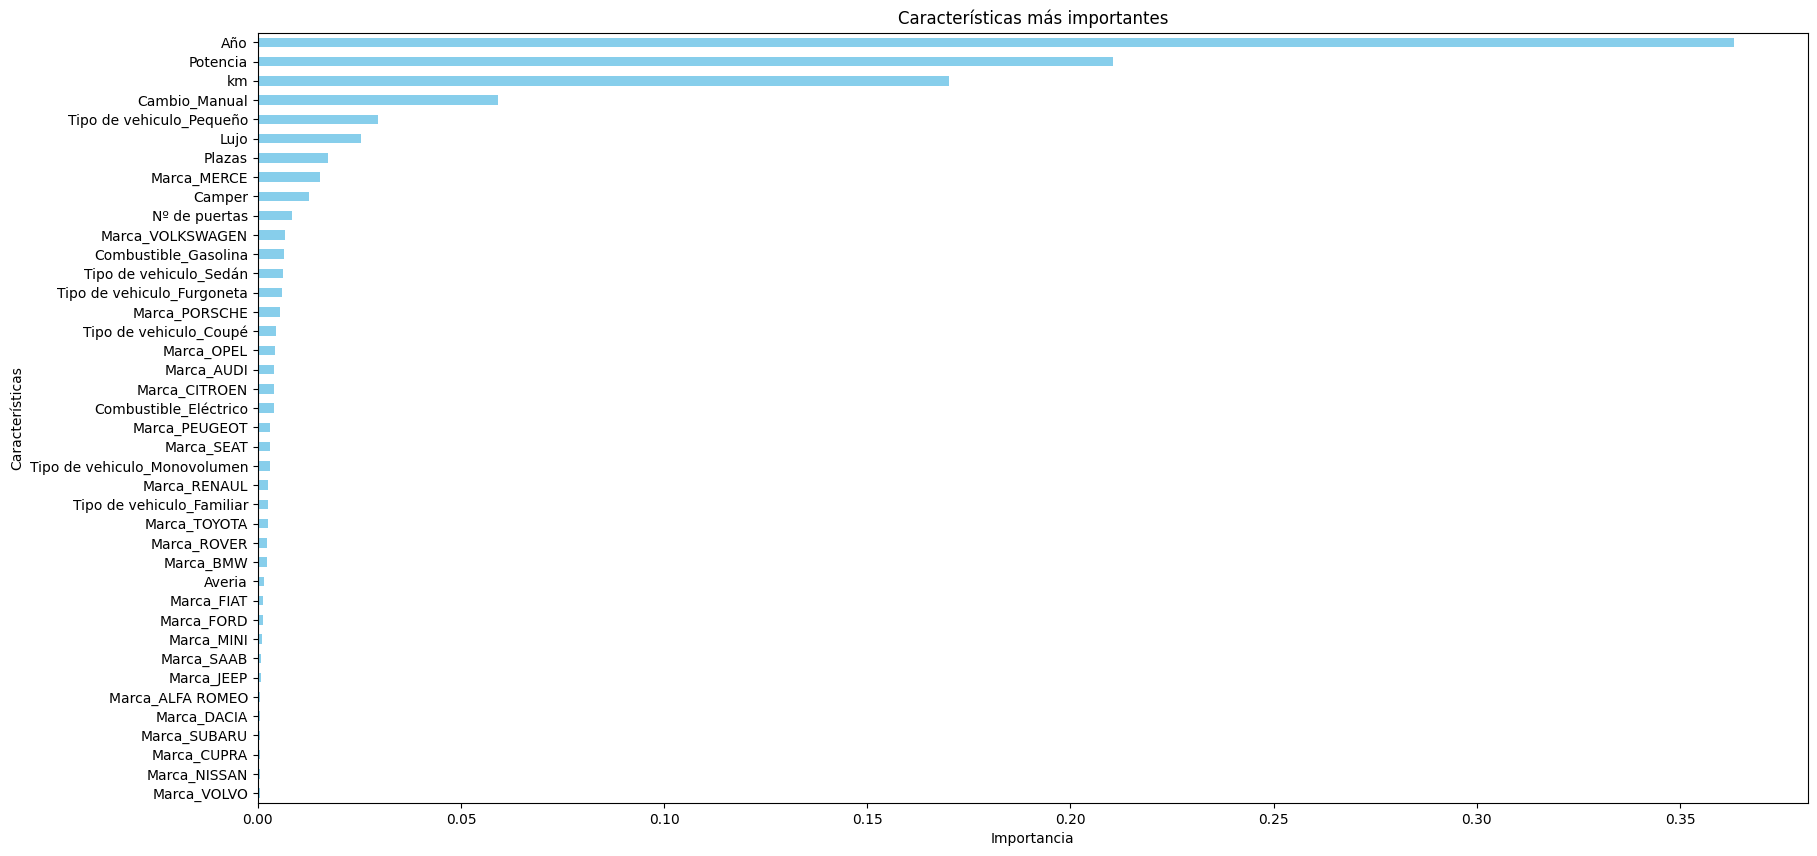

In [10]:
# GradientBoosting

from sklearn.ensemble import GradientBoostingRegressor
# Supongamos que ya tienes cargados X_train, X_test, y_train, y_test
# Parámetros del modelo
params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 1000,
    'subsample': 1.0
}
# Crear el modelo de Gradient Boosting Regressor
model = GradientBoostingRegressor(**params)
# Entrenar el modelo
model.fit(X_train, y_train)
# Predecir valores en el conjunto de prueba
y_pred = model.predict(X_test)
# Predecir valores en el conjunto de entrenamiento
yhat_train = model.predict(X_train)
# Calcular el R^2 para entrenamiento y prueba
print('Entrenamiento: ', r2_score(y_train, yhat_train))
print('Test: ', r2_score(y_test, y_pred))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Crear un DataFrame con las características importantes
features = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])
data = pd.DataFrame(data=importances[indices], index=features[indices], columns=["score"])
# Graficar las 40 características más importantes
plt.figure(figsize=(20, 10))
data.nlargest(40, columns="score").plot(kind='barh', figsize=(20, 10), color='skyblue', legend=None)
plt.title('Características más importantes')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté en la parte superior
plt.show()

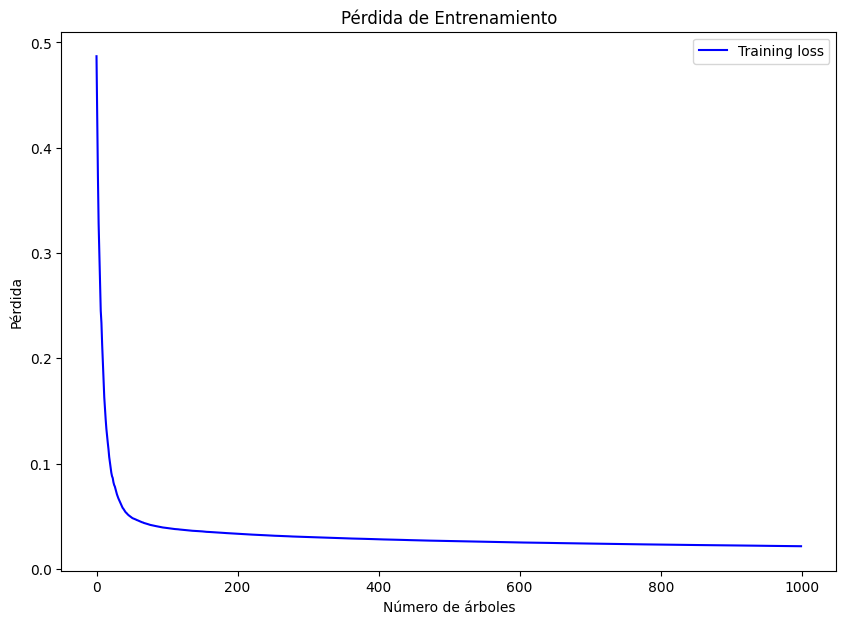

In [11]:
# Si deseas graficar las pérdidas de entrenamiento y validación
# (Esto asume que tienes algún tipo de validación cruzada o early stopping implementado)
# Graficar la pérdida
plt.figure(figsize=(10, 7))
if hasattr(model, 'train_score_'):
    plt.plot(np.arange(len(model.train_score_)), model.train_score_, label='Training loss', color='blue')
plt.xlabel("Número de árboles")
plt.ylabel("Pérdida")
plt.title('Pérdida de Entrenamiento')
plt.legend()
plt.show()

In [ ]:
# De los 3 modelos, se acaba eligiendo el XGBoost

In [9]:
df_final=ver_error(xtrain_normal,xtest_normal,y_train,y_test,yhat_train,yhat_test)

In [11]:
df_final[['Precio','Prediccion','Error','AbsError']].describe()

,Precio,Prediccion,Error,AbsError
count,50355.000000,50355.000000,50355.000000,50355.000000
mean,19112.451494,18672.150391,-440.300343,2499.485943
std,11222.361338,10274.255859,3505.181794,2496.520299
min,1000.000000,1340.176758,-20084.743164,0.000977
25%,10490.000000,10594.348633,-1941.845703,728.410645
50%,17300.000000,17402.597656,-22.571289,1698.589844
75%,26800.000000,26348.076172,1506.905884,3417.222656
max,50000.000000,48854.894531,13660.115234,20084.743164


In [20]:
df_final_sorted = df_final.sort_values(by='AbsError',ascending=False)

In [21]:
df_final

,Marca,Año,Potencia,Plazas,Nº de puertas,km,Tipo de vehiculo,Combustible,Cambio,Lujo,Averia,Camper,Precio,Prediccion,Error,AbsError
10752,PEUGEOT,2019,100,5,5,82110,Sedán,Diésel,Manual,False,0,0,9490.0,11707.731445,2217.731445,2217.731445
30684,AUDI,2016,310,2,2,110000,Coupé,Gasolina,Manual,True,0,0,32490.0,33947.078125,1457.078125,1457.078125
37859,MERCE,2019,170,5,5,90000,4x4,Diésel,Automático,True,0,0,36500.0,31311.953125,-5188.046875,5188.046875
49687,AUDI,2021,204,5,5,40000,Familiar,Diésel,Automático,True,0,0,41900.0,37561.515625,-4338.484375,4338.484375
45550,PEUGEOT,2011,240,2,2,3000,Pequeño,Gasolina,Manual,False,0,0,17000.0,19199.791016,2199.791016,2199.791016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23505,VOLKSWAGEN,2016,120,5,5,93700,Familiar,Diésel,Manual,False,0,0,14900.0,13948.457031,-951.542969,951.542969
14318,PEUGEOT,2020,100,5,5,159900,Monovolumen,Diésel,Manual,False,0,0,11850.0,11127.947266,-722.052734,722.052734
23027,FIAT,2020,95,5,5,41675,4x4,Diésel,Manual,False,0,0,14355.0,13661.175781,-693.824219,693.824219
30222,FIAT,2020,140,6,5,160000,Furgoneta,Diésel,Manual,False,0,0,19900.0,20472.736328,572.736328,572.736328


In [22]:
df_final_sorted

,Marca,Año,Potencia,Plazas,Nº de puertas,km,Tipo de vehiculo,Combustible,Cambio,Lujo,Averia,Camper,Precio,Prediccion,Error,AbsError
18364,ROVER,2003,122,5,4,112000,4x4,Diésel,Manual,False,0,0,30000.0,9915.256836,-20084.743164,20084.743164
30743,ROVER,2006,122,5,5,139600,4x4,Diésel,Manual,False,0,0,32500.0,12558.885742,-19941.114258,19941.114258
38444,VOLKSWAGEN,2009,130,4,4,130000,Furgoneta,Diésel,Manual,False,0,0,37900.0,18555.716797,-19344.283203,19344.283203
48609,ROVER,2005,122,2,2,230000,4x4,Diésel,Manual,False,0,0,27500.0,8324.668945,-19175.331055,19175.331055
19144,VOLKSWAGEN,2007,130,4,4,212000,Furgoneta,Diésel,Manual,False,0,0,32000.0,13029.170898,-18970.829102,18970.829102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39255,PEUGEOT,2021,180,7,5,57753,4x4,Diésel,Automático,False,0,0,29990.0,29989.919922,-0.080078,0.080078
10740,FIAT,2016,120,5,5,190000,Monovolumen,Diésel,Manual,False,0,0,9275.0,9274.952148,-0.047852,0.047852
36118,CITROEN,2005,110,5,5,187704,Pequeño,Diésel,Manual,False,0,0,2530.0,2529.960449,-0.039551,0.039551
12464,PEUGEOT,2014,92,5,5,43341,Pequeño,Diésel,Automático,False,1,0,10450.0,10450.031250,0.031250,0.031250


In [45]:
# Guardamos el modelo entrenado

import joblib

joblib.dump(modelo, 'modelo_entrenado2.joblib')


['modelo_entrenado.joblib']